# FastAI Practice: Image Classification

Creating an image recognition model with FastAI to classify ToonTown entities (Cogs vs Toons)


## Future enhancements:

-    [Bounding boxes](https://docs.fast.ai/tutorial.datablock.html#Bounding-boxes) around the entities

-    [Polygonal segmentation](http://www.cs.toronto.edu/polyrnn/) around the entities

## Necessary enhancements:

1.    Find the optimal learning rate
1.    Improve entity images to remove backgrounds

## Notebook TODO: 

1.    Write about uploading to JarvisLabs to improve the `error_rate`

In [1]:
from fastai.data.transforms import get_image_files
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.imports import Path
from typing import List

path_all_imgs = Path('images/entity')
# path_all_imgs.ls()

## Retrieve and verify all entity images

Display an image of a Yesman

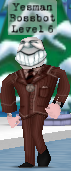

In [2]:
all_imgs = get_image_files(path=path_all_imgs)
len(all_imgs)
failed_imgs = verify_images(all_imgs)
assert len(failed_imgs) == 0
# failed_imgs.map(Path.unlink)
img = Image.open(all_imgs[31])
img

## Define a function to retrieve labels from the image's filename

This function will be used in FastAI's `DataBlock` class for retrieving labels.

### Current image filename format is as follows:
-    Cogs:  entity_cog_COGNAME#.png
-    Toons: entity_toon_TOONSPECIES#.png

In the future, we'll train the model to recognize specifics about the entity; such as...
-    Cog name, suit (Bossbot, Cashbot, Lawbot, Sellbot), maybe minimum level (1-7)
-    Toon species (dog, cat, bunny, duck, horse, mouse, monkey, bear, pig, crocodile, deer)


> NOTE: We could utilize FastAI's `RegexLabeller` in the future instead of this function. I left examples of `RegexLabeller` in the following cell. 

In [2]:
def get_entity_label_from_path(path: Path) -> str:
    return 'cog' if 'cog' in path.name else 'toon'

## Create `DataBlock` and `DataLoaders` objects for the entity images

Perform a random 70/30 split for training/validation sets. Ensure the seed is always 31 so we always have the same images in the training and validation sets.

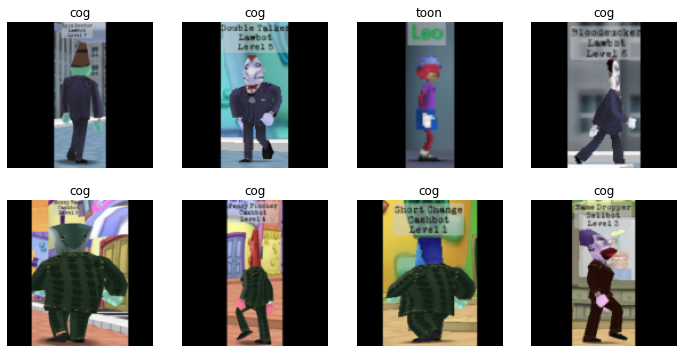

In [4]:
entity_types = ['cog', 'toon']
entities_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.3, seed=31),
    # get_y=RegexLabeller(fr'{path_all_imgs}/entity_(\w+_\w+)\d.png'),  # cog_backstabber, toon_deer
    # get_y=RegexLabeller(fr'{path_all_imgs}/entity_(\w+)_.*'),         # cog, toon
    get_y=get_entity_label_from_path,
    # item_tfms=Resize(128, ResizeMethod.Squish)
    item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')
    # item_tfms=Resize(128)
)
entities_datablock
entities_dataloaders = entities_datablock.dataloaders(source=path_all_imgs)
entities_dataloaders.valid.show_batch(max_n=8, nrows=2)


## Create a new `DataLoaders` object with augmented images scaled to 224x224px

Augmentation performs batch transforms that randomly resize and crop all images.

In [5]:
# entities = entities_datablock.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms()
# )
entities_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=31),
    get_y=get_entity_label_from_path,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = entities_datablock.dataloaders(path_all_imgs)


/home/sason/Projects/FastAI/fastai_env/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


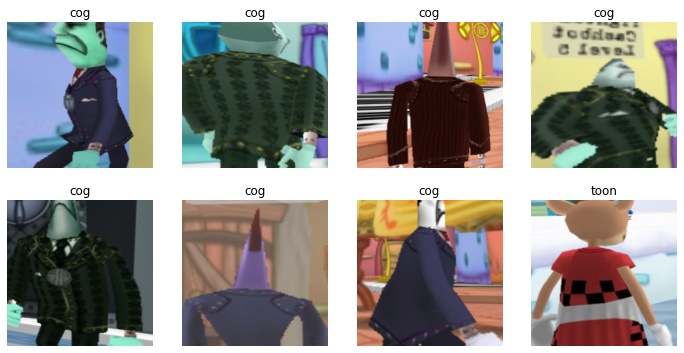

In [6]:
dls.train.show_batch(max_n=8, nrows=2, unique=False)

----

## Train the model against the `resnet18` architecture for 5 epochs

Other models may be found here: [FastAIv2 Docs](https://docs.fast.ai/vision.models.xresnet.html)  
I found the resnet models in the FastAIv1 docs: [FastAIv1 Docs](https://fastai1.fast.ai/vision.models.html)

In [ ]:
learner = cnn_learner(dls=dls, arch=resnet18, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time
0,1.251941,0.433272,0.125000,00:18


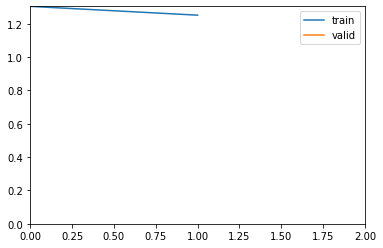

epoch,train_loss,valid_loss,error_rate,time
0,1.053339,0.446997,0.250000,00:31
1,1.019614,0.543601,0.275000,00:27
2,0.906836,0.420588,0.200000,00:26
3,0.812925,0.342182,0.175000,00:26
4,0.770686,0.316094,0.150000,00:25


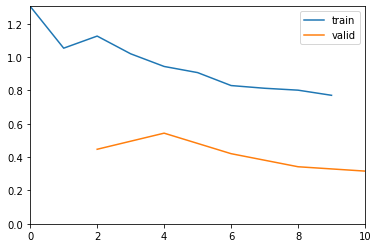

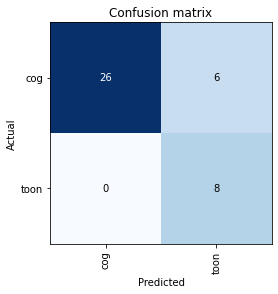

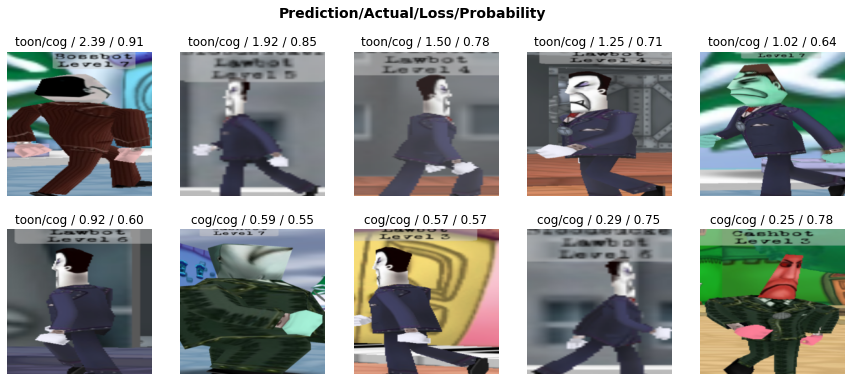

In [10]:
learner.fine_tune(5, cbs=[ShowGraphCallback()])
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()
interp.plot_top_losses(10, nrows=2)

15% `error_rate` isn't accurate enough for me. Let's try to improve the `error_rate`.

### Fine-tune the model for another 15 epochs, for a total of 20 epochs, to see if the `error_rate` decreases

epoch,train_loss,valid_loss,error_rate,time
0,0.497192,0.229742,0.100000,00:19


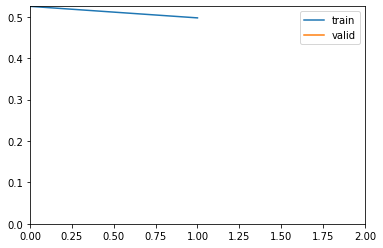

epoch,train_loss,valid_loss,error_rate,time
0,0.297784,0.294996,0.125000,00:29
1,0.344939,0.298200,0.150000,00:33
2,0.399249,0.269284,0.150000,00:26
3,0.406231,0.284070,0.125000,00:28
4,0.394584,0.319226,0.150000,00:27
5,0.378844,0.316030,0.125000,00:34
6,0.351897,0.278285,0.150000,00:26
7,0.320283,0.217048,0.125000,00:25
8,0.316504,0.204763,0.125000,00:30
9,0.284154,0.152504,0.075000,00:25


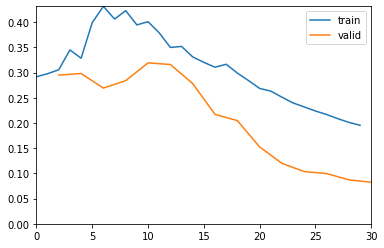

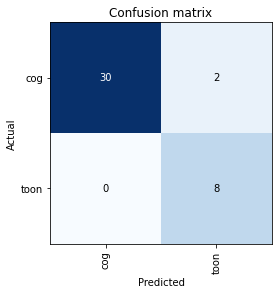

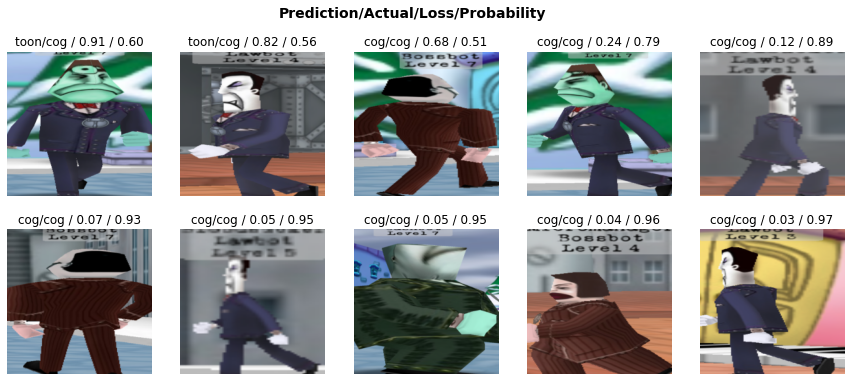

In [11]:
learner.fine_tune(15, cbs=[ShowGraphCallback()])
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()
interp.plot_top_losses(10, nrows=2)


The `error_rate` seems to be stuck around 5-15%, which is not good for such a simple dataset.

## What could improve the error rate?

- Using an optimal learning rate?
- Trying other resnet architectures with more layers?
- Remove background and entity name boxes from trainig/validation sets

### Using an optimal learning rate with `learner.lr_find()`

The learning finder can be read about here [05_pet_breeds.ipynb](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb#The-Learning-Rate-Finder)

> What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

In [ ]:
lr_min = learner.lr_find()  # Takes 20 minutes on my laptop...
lr_min.valley

## Widget for uploading images and classifying against all resnet models

1.    Load all the models exported from my training server
1.    Map each model to the resnet number and a ipywidget `Label` object
1.    Create 2 buttons for uploading a photo and classifying the image
1.    Define a function to classify the image against all exported models
1.    Assign the prediction and probability value to the model's `Label`

In [44]:
learner18_inference = load_learner('learners/learner_resnet18.pkl')
learner34_inference = load_learner('learners/learner_resnet34.pkl')
learner50_inference = load_learner('learners/learner_resnet50.pkl')
# learner101_inference = load_learner('learners/learner_resnet101.pkl')
# learner152_inference = load_learner('learners/learner_resnet152.pkl')
all_models = {
    '18': [learner18_inference, widgets.Label()],
    '34': [learner34_inference, widgets.Label()],
    '50': [learner50_inference, widgets.Label()],
    # '101': [learner101_inference, widgets.Label()],
    # '152': [learner152_inference, widgets.Label()]
}
all_labels = [model[1] for model in all_models.values()]


In [71]:
button_classify = widgets.Button(description='Classify')
button_upload = widgets.FileUpload()
out_pl = widgets.Output()


def on_click_classify(change):
    img = PILImage.create(button_upload.data[-1])
    out_pl.clear_output()

    for model_name in all_models:
        model, label = all_models[model_name]
        pred,pred_idx,probs = model.predict(img)
        label.value = f'Resnet{model_name} : {pred} ({probs[pred_idx]*100:.02f}%)'
    with out_pl:
        display(img.to_thumb(224, 224))

button_classify.on_click(callback=on_click_classify)

VBox([widgets.Label('Select your entity!'), button_upload, button_classify, out_pl] + all_labels)